**Install PyTorch Geometric** and set params

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.6-cp37-cp37m-linux_x86_64.whl size=292563 sha256=16f16e498911cd4ded18870f9a2767e3635f08a32d718a49368ef9decfb91588
  Stored in directory: /root/.cache/pip/wheels/d6/bf/04/7c9e0c1466d37548e5c7c7c2daee2b7f90ce616f102c68bf07
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
  Created wheel for torch-sparse: filename=torch_sparse-0.6.9-cp37-cp37m-linux_x86_64.whl size=432297 sha256=ffcfcf0741551322e5f339745f1fc19ccdc1cc4f23ca2cc680cc03ec93a23664
  Stored in directory: /root/.cache/pip/wheels/6c/9f/3e/8813c1f7e87d12b01b830d3506e7f3f6b044d9d53769057ddb
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
  Created wheel for torch-cluster: filename=torch_cluster-1.5.9-cp37-cp37m-linux_x86_64.whl size=391561 sha256=93876b0c92cb3be5965bf445a8b7ca1e9b6

In [2]:
import numpy as np
np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load Dataset.**

Here we use an ENZYMES dataset (consisting of 600 graphs within 6 classes) from "TUDataset".

- PyTorch Geometric has more built-in benchmark dataset available (citation networks, molecules, 3d point clouds, etc.), you can check them out here: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#common-benchmark-datasets 

- To understand the data structure of pytorch geometric graphs: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs

- You can also create your own dataset: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html 

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')


dataset = dataset.shuffle()
train_dataset = dataset[:450]
val_dataset = dataset[450:550]
test_dataset = dataset[550:]

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [4]:
# Take a look at the dataset!
print('length of dataset:', len(dataset))
print('number of classes:', dataset.num_classes)
print('node feature dimension:', dataset.num_node_features)
data = dataset[0]
print(data.is_undirected())
print(data)

print('We can see that the first graph in the shuffled dataset contains {} nodes, each one having {} features. \
There are {} undirected edges and the graph is assigned to exactly one class.'.format(data.x.shape[0], data.x.shape[1],
                                                                                         data.edge_index.shape[1]//2))

length of dataset: 600
number of classes: 6
node feature dimension: 3
True
Data(edge_index=[2, 164], x=[45, 3], y=[1])
We can see that the first graph in the shuffled dataset contains 45 nodes, each one having 3 features. There are 82 undirected edges and the graph is assigned to exactly one class.


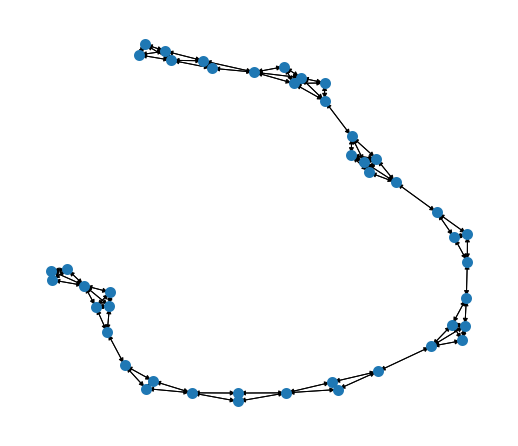

In [6]:
# if you want to visualize the graph...

! pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

viz_g = to_networkx(data)

plt.figure(1,figsize=(7,6)) 
nx.draw(viz_g, cmap=plt.get_cmap('Set1'),node_size=25,linewidths=6)
plt.show()

**Build model**

Here for the demo purpose, we only consider a simple model consisting of 2 GCNConv layers followed by a global max pooling layer to get the graph representaiton, but there are many more better performing layers / models you can work with in the PyTorch geometric. They include almost all recent graph convnet models and even if you don't want to use this library, you can check out their implementations as a reference. 

For a complete model/layer list and their algorithms (including the GCNConv we'll use here), check out: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html 

For this particular dataset, you can check out its current leaderboard and play with the model to achieve a better performance: https://paperswithcode.com/sota/graph-classification-on-enzymes 

In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool

class Net(torch.nn.Module):
    def __init__(self, hidn=16):
        super(Net, self).__init__()
        ### 1 layer
        # self.conv1 = GCNConv(dataset.num_node_features, dataset.num_classes)

        ### 2 layers
        self.conv1 = GCNConv(dataset.num_node_features, hidn)
        self.conv2 = GCNConv(hidn, dataset.num_classes)
        

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index

        ### 1 layer
        # x = self.conv1(x, edge_index)

        ### 2 layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_max_pool(x, batch)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

**Training**

One notice here: "batch" attribute in "batch_data.batch" below is a column vector indicating each node's graph, more about bathcing in PyTorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches 

In [8]:
from torch_geometric.data import DataLoader

### training parameters
num_epochs = 500
batch_size = 64
lr = 5e-3
weight_decay = 5e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### training loops
train_accs = []
val_accs = []
max_acc = 0
for epoch in range(num_epochs):

  ## train
  model.train()
  correct = 0
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  for batch_data in train_loader:
    optimizer.zero_grad()
    out = model(batch_data, batch_data.batch)
    loss = F.nll_loss(out, batch_data.y)
    loss.backward()
    optimizer.step()
    _, pred = out.max(dim=1)
    correct += int(pred.eq(batch_data.y).sum().item())
  train_acc = correct / int(len(train_dataset))
  train_accs.append(train_acc)
  
  ## validation
  model.eval()
  correct = 0
  for batch_data in val_loader:
    with torch.no_grad():
      _, pred = model(batch_data, batch_data.batch).max(dim=1)
    correct += int(pred.eq(batch_data.y).sum().item())
  val_acc = correct / int(len(val_dataset))
  val_accs.append(val_acc)

  # save the best model and print out accuracies
  if val_acc > max_acc:
    max_acc = val_acc
    torch.save(model.state_dict(), 'enzyme_model.pth')
    print('Epoch {}, training accuracy: {:.4f}, validation accuracy: {:.4f}'.format(epoch, train_acc, val_acc))
print('best validation accuracy:', max_acc)

Epoch 0, training accuracy: 0.1600, validation accuracy: 0.2400
Epoch 7, training accuracy: 0.1956, validation accuracy: 0.2500
Epoch 12, training accuracy: 0.2044, validation accuracy: 0.2900
Epoch 53, training accuracy: 0.2400, validation accuracy: 0.3000
Epoch 213, training accuracy: 0.2600, validation accuracy: 0.3100
Epoch 242, training accuracy: 0.2667, validation accuracy: 0.3300
best validation accuracy: 0.33


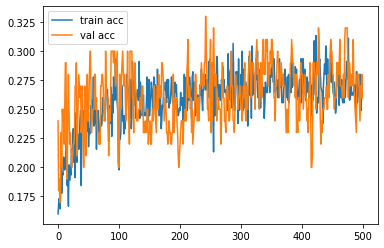

In [9]:
### plot train & val acc curves v.s. epochs
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
plt.show()

**Testing**

In [11]:
test_loader = DataLoader(test_dataset, batch_size= batch_size)

## testing
model.eval()
correct = 0

for batch_data in test_loader:
  with torch.no_grad():
    _, pred = model(batch_data, batch_data.batch).max(dim=1)
  s = pred.eq(batch_data.y).sum()
  print(s)
  correct += int(pred.eq(batch_data.y).sum().item())

test_acc = correct / int(len(val_dataset))
print("test accuracy:", test_acc)


tensor(16)
test accuracy: 0.16
